In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image



In [5]:
tf.__version__

'2.8.0'

In [8]:
vgg = tf.keras.applications.VGG19(include_top = False, weights='imagenet')
print()
for layer in vgg.layers:
    print(layer.name)
    



input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
print(vgg19)

NameError: name 'vgg19' is not defined

In [10]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)
    
    if max_size is not None:
        factor = max_size / np.max(image.size)
        size = np.array(image.size)*factor
        size = size.astype(int)
        image = image.resize(size, PIL.Image.LANCZOS)
    return np.float32(image)

In [11]:
def save_image(image, filename):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')
        

In [12]:
def plot_image_big(image):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    # image.show()
    plt.imshow(np.squeeze(image))  
    plt.show()
    

In [13]:
def plot_images(content_image, style_image, mixed_image):
    fig, axes = plt.subplots(1,3, figsize=(10,10))
    fig.subplots_adjust(hspace=0.1, espace=0.1)
    
    smooth = True
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation= 'nearest'
        
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation = interpolation)
    ax.set_xlable('content ')
    
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation = interpolation)
    ax.set_xlable('mixed')
    
    ax = axes.flat[2]
    ax.imshow(style_image/ 255.0, interpolation = interpolation )
    ax.set_xlable('style')
    
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [14]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a-b))

In [15]:
def create_content_loss(session, model, content_image, layer_ids):
    feed_dict = model.create_feed_dict(image=content_image)
    
    layers = model.get_layer_tensors(layer_ids)
    
    values = session.run(layers, feed_dict=feed_dict)
    
    with model.graph.as_default():
        layers_losses = []
        
        for value, layer in zip(values, layers):
            value_const = tf.constant(value)
            
            loss = mean_squared_error(layer, value_const)
            
            layers_losses.append(loss)
            
        total_loss=tf.reduce_mean(layers_losses)
    
    return total_loss

In [16]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    num_channel=int(shape[3])
    
    matrix = tf.reshape(tensor, shape=[-1, num_channel])
    
    gram = tf.matmul(tf.transpose(matrix), matrix)
    
    return gram

In [17]:
def create_style_loss( session, model, style_image, layer_ids):
    feed_dict = model.create_feed_dict(image=style_image)
    
    layers = model.get_layer_tensors(layer_ids)
    
    with model.graph.as_default():
        
        gram_layers = [gram_matrix(layers) for layer in layers]
        
        values = session.run(gram_layers, feed_dict=feed_dict)
        
        
        
        layer_losses = []
        
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)
        
        total_loss = tf.reduce_mean(layer_losses)

In [18]:
def create_denoise_loss(model):
    loss = tf.reduce_mean(tf.abs(model.input[:,1:,:,:]-model.input[:,:-1,:,:]))+\
           tf.reduce_mean(tf.abs(model.input[:,:,1:,:]-model.input[:,:,:-1,:]))
    return loss

In [19]:
def style_transfer(content_image, style_image, 
                   content_layer_ids, style_layer_ids,
                   weight_content=1.3, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):

    model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    model.trainable = False
    
    session = tf.InteractiveSession(graph=model.graph)
    
    print("content_layers:")
    print(model.get_layer_names(content_layer_ids))
    print()
    
    print("style_layers:")
    print(model.get_layer_names(style_layer_ids))
    print()
    
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids,
                                       )
    loss_style = create_style_loss(session=session,
                                       model=model,
                                       style_image=style_image,
                                       layer_ids=style_layer_ids,
                                       )
    
    loss_denoise = create_denoise_loss(model)
    
    adj_content = tf.Variable(1e-10, name = 'adj_content')
    adj_style = tf.Variable(1e-10, name="adj_style")
    adj_denoise = tf.Variable(1e-10, name="adj_denoise")
    
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initialiser])
    
    update_adj_content = adj_content.assign(1.0/(loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0/(loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0/(loss_denoise + 1e-10))
    
    loss_combined = weight_content *adj_content * loss_content + weight_style * adj_style*loss_style + weight_denoise * adj_denoise * loss_denoise

    gradient = tf.graidients(loss_combined, model.input)
    
    run_list = [gradient, update_adj_content, update_adj_style, update_adj_denoise]
    
    mixed_image = np.random.rand(*content_image.shape)+128
    
    for i in range(num_iterations):
        
        feed_dict = model.create_feed_dict( image = mixed_image)
        
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        =session .run (run_list, feed_dict=feed_dict)
            
        grad = np.squeeze(grad)
            
        step_size_scaled = step_size / (np.std(grad)+ 1e-8)
        
        mixed_image -= grad * step_size_scaled
        
        mixed_image = np.clip(mixed_image, 0.0, 255.0)    
        
        print(". ", end = "")
              
        if(i % 10 ==0)or(i==num_iterations -1):
            print()
            print("iteration:", i)
            
            msg = "Weight adj. for content: {0: .2e}, style: {1:.2e}, denoise: {3: .2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))
            
            plot_images(content_image = content_image, style_image=style_image,mixed_image = mixed_image)
        
        print()
        print('final image')
        plot_image_big(mixed_image)
        
        session.close()
        
        return mixed_image
        
                  
    
    
    

In [20]:
content_path = './images/Elevator.jpg'
style_path = './images/durer.jpg'

content_image = load_image(content_path)
style_image = load_image(style_path)


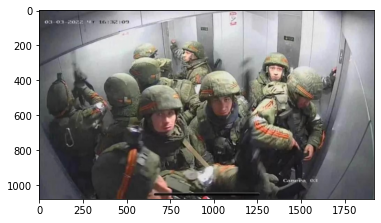

In [14]:
random_image = load_image("images/Elevator.jpg")
plot_image_big(random_image)



In [ ]:
content_layer_ids=[4]

In [ ]:
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content =1.5,
                     weight_style=10.0,
                     weight_denoise = 0.3,
                     mum_iterations = 60,
                     step_size = 10.0
                     )